In [1]:
import CO2_Dataset_Preparation
import ML_Model_Master
import Result_Retriever

from CO2_Dataset_Preparation import *
from ML_Model_Master import *
from Result_Retriever import *
from datetime import datetime
import pickle

import importlib
importlib.reload(CO2_Dataset_Preparation)
importlib.reload(ML_Model_Master)
importlib.reload(Result_Retriever)

from CO2_Dataset_Preparation import *
from ML_Model_Master import *
from Result_Retriever import *


Using TensorFlow backend.


In [287]:
#Data parameters
position_number = 2
excess_rolls = [60]#,6000,36000] #these specify the rolling window on which a minimum is applied for excess 
feature_columns = ['CO2_1','ws','wd']#,'Pic_CH4','ANEM_X','ANEM_Y','ANEM_Z','wd','ws']
downsample_sec = 60
periods_to_lag = 2
tower = 'Multi'
train_percent = 0.7

#Model Parameters
activation = 'relu'
neurons = 256
dropout_rate = 0.2
learn_rate = 0.001
decay = 1e-5
batch_size = 20
epochs = 20
error_metric = 'rmse'

logfile = None

In [288]:
#Preprocess data and save as pkl

data = Processed_Set(tower,position_number,excess_rolls,vent_bool =True,wbb_bool=False)
data._retrieve_data('../CO2_Data_Processed/')
data._apply_excess()

# ml_data = ML_Data(downsample_sec,periods_to_lag,tower,train_percent)
# ml_data._ML_Process(data,lag_how='both')

# with open('ML_dataset_{}DS.pkl'.format(downsample_sec), 'wb') as file:
#     pickle.dump(ml_data, file)



Applying excess using minimum on windows: [60]


In [300]:
ml_data = ML_Data(downsample_sec,periods_to_lag,tower,train_percent,feature_columns = feature_columns)
ml_data._ML_Process(data,lag_how='both')


Downsampling by mean at 60 seconds
Downsampling by mean at 60 seconds


In [301]:
ml_data.feature_and_target

['CO2_1', 'ws', 'wd', 'm_dot']

In [302]:
ml_model._train_model(ml_data)


Downsampling = 60
Lag Periods = 2        
activation=relu
neurons=256
dropout_rate=0.2        
learn_rate=0.001
decay=1e-05
batch size=20
epochs=10


ValueError: Error when checking input: expected sequential_7_input to have shape (4, 9) but got array with shape (4, 3)

Fitting data from X_test


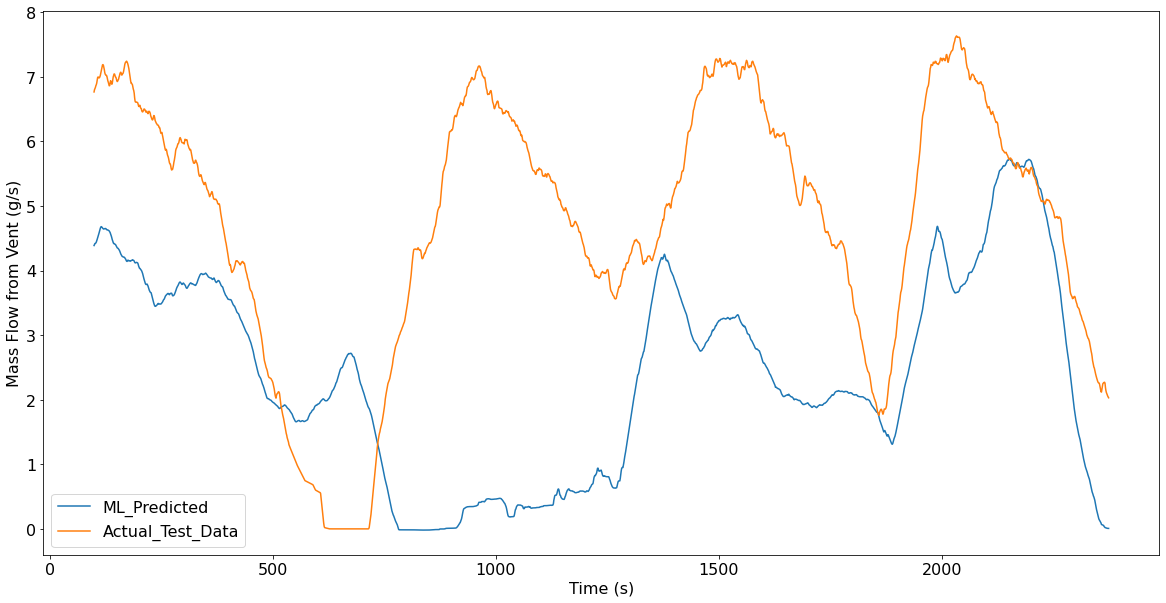

In [278]:
import matplotlib.pyplot as plt

ml_model._fit_data(ml_data)

#Return to original data shape and scale
X_test_original_shape = ml_data.X_test.reshape(ml_data.orig_X_test_shape) #reshape from 3d time
y_test_original_shape = ml_data.y_test.reshape(ml_data.orig_y_test_shape)#reshape from 3d time 

merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1) #concat X and y
unscaled_test = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1] #unscale using declared scalar

y_fit_original_shape = ml_data.y_fit.reshape(ml_data.orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled_fit = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

#Put into pandas df
comparison = pd.concat([unscaled_test,unscaled_fit],axis=1)
comparison.columns = ['test','fit']

#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (20,10))
# ax.plot(ml_data.y_fit,label='ML_Fit_to_Test')
# ax.plot(ml_data.y_test,label='Actual_Test_Data')

roll = 100

ax.plot(comparison['fit'].rolling(roll).mean(),label='ML_Predicted')
ax.plot(comparison['test'].rolling(roll).mean(),label='Actual_Test_Data')

ax.set_xlabel('Time (s)',fontsize=16)
ax.set_ylabel('Mass Flow from Vent (g/s)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)


ax.legend(fontsize=16)
plt.show()

# ----------
# Results Retrieve
# ----------

-----Plotting Best Model Comparison-----


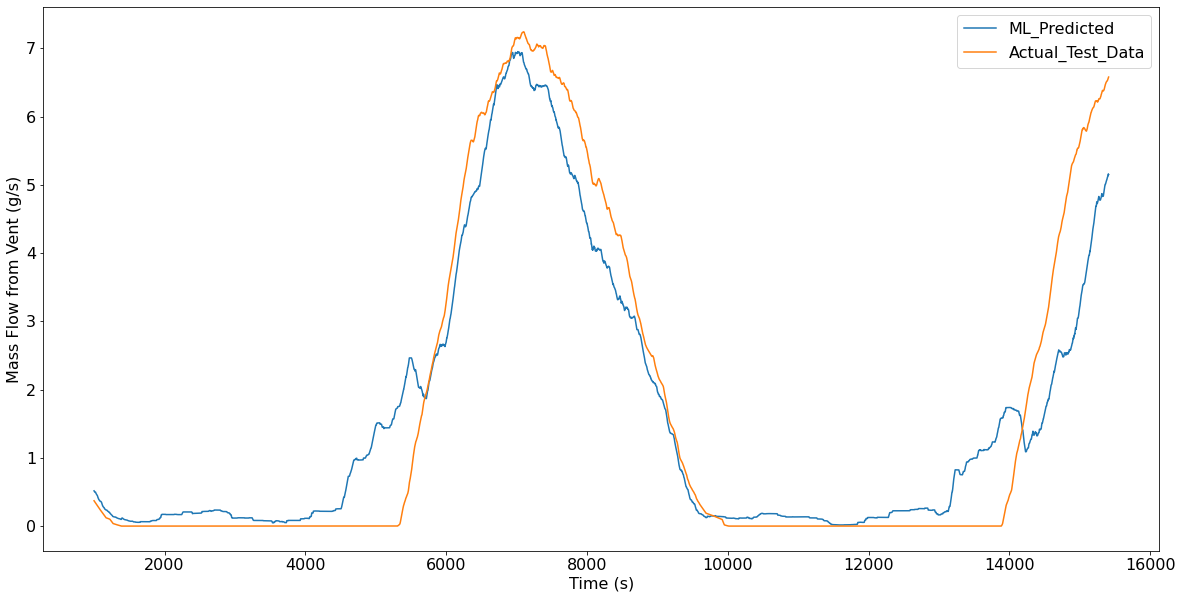

In [3]:
from Result_Retriever import *

# logfile = f'Gridsearch_Output/Picarro_CH4in_PN4_DS10_Lag6_Train0.8.out'
# g = Gridsearch_Result_Retrieve(logfile)
# g._read_data_vars()
# g._read_models()
# g._find_best_model()
# g._get_best_data('../CO2_Data_Processed/')
# g._retrain_fit_best()
g._plot_best_comparison(1000)

In [3]:
l = g.last_error
from operator import itemgetter
top_ten = sorted(enumerate(l),key=itemgetter(1))[0:10]
top_idx = [i[0]for i in top_ten]
top_models = []
for i in top_idx:
    top_models.append(g.models[i])
top_attr = {'neurons':[],'dropout_rate':[],'learn_rate':[],'decay':[],'batch_size':[],'epochs':[]}
for mod in top_models:
    top_attr['neurons'].append(mod.neurons)
    top_attr['dropout_rate'].append(mod.dropout_rate)
    top_attr['learn_rate'].append(mod.learn_rate)
    top_attr['decay'].append(mod.decay)
    top_attr['batch_size'].append(mod.batch_size)
    top_attr['epochs'].append(mod.epochs)

In [ ]:
file_name =f'{logfile}_trained.pkl'
with open('{}.pkl'.format(file_name), 'wb') as file:
    pickle.dump(g, file)

In [4]:
file_name =f'{logfile}_trained.pkl'
with open('{}.pkl'.format(file_name), 'rb') as file:
    g = pickle.load(file)

/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
